# Stepwise Attention Modulation with Text-IP Ratio Adjustment

In [ ]:
import torch
from diffusers import TimeStableDiffusionPipeline, StableDiffusionPipeline, DDIMScheduler, AutoencoderKL
from PIL import Image
from ip_adapter import TimeIPAdapter
import time
import yaml
import os

In [29]:
import matplotlib.pyplot as plt

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def plot_weights(title, inference_steps, text_weights, time_weights, fig_name):
    plt.style.use(plt.style.available[10])

    # Text weight plot
    plt.plot(inference_steps, text_weights, label='text weight', color='blue', linewidth=2, alpha=0.8)
    
    # Time weight plot
    plt.plot(inference_steps, time_weights, label='image weight', color='red', linewidth=2, alpha=0.8)

    plt.xlim(1000, 0)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Labels and title
    plt.xlabel('Step', fontsize=20)
    plt.ylabel('Weight', fontsize=20)
    # plt.title(title, fontsize=14, fontweight='bold')
    
    # Show legend
    plt.legend(loc='upper left', fontsize=20)

    # Display the plot
    plt.savefig(fig_name)
    plt.show()
    
def save_config(input_image_path, output_image_path, text_prompt, scale, step, ratio, config_path):
    config_data = {
        "Input image" : input_image_path,
        "Output image": output_image_path,
        "Text" : text_prompt,
        "Type": type,
        "Scale": scale,
        "Step": step,
        "Ratio": ratio,
    }
    try:
        with open(config_path, 'r') as file:
            existing_data = yaml.safe_load(file)
            if existing_data is None:
                existing_data = []
    except FileNotFoundError:
        existing_data = []
    if isinstance(existing_data, list):
        existing_data.append(config_data)
    else:
        existing_data = [existing_data, config_data]
    with open(config_path, 'w') as file:
        yaml.dump(existing_data, file, default_flow_style=False)

In [8]:
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "../models/image_encoder/"  # https://huggingface.co/h94/IP-Adapter
ip_ckpt = "../models/ip-adapter_sd15.bin" # https://huggingface.co/h94/IP-Adapter
device = "cuda:0"

In [9]:
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

# load SD pipeline
pipe_time = TimeStableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

ip_model_time = TimeIPAdapter(pipe_time, image_encoder_path, ip_ckpt, device, time_attention=True)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

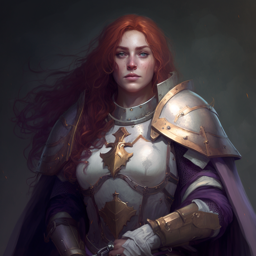

In [10]:
# read image prompt
input_image_path = "../assets/images/woman.png"
image = Image.open(input_image_path)
image.resize((256, 256))

In [34]:
text_prompt = "best quality, high quality, a close-up of a woman smiling with the city skyline"
scale = 1.0

  0%|          | 0/50 [00:00<?, ?it/s]

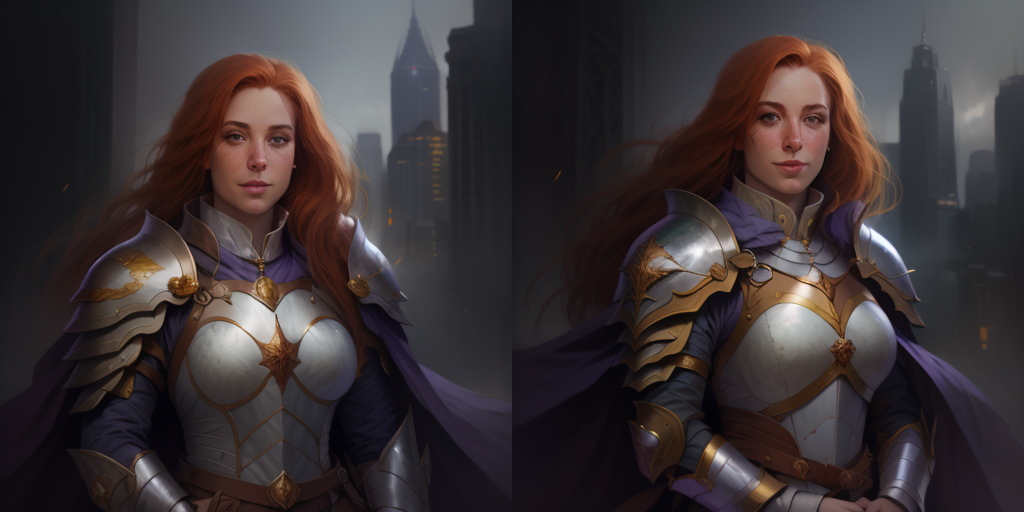

In [37]:
type = "stepwise"
step = 0
ratio_idx = 5
if ratio_idx == 0:
    ratio = {"text":1, "ip":0}
elif ratio_idx == 1:
    ratio = {"text":0.8, "ip":0.2}
elif ratio_idx == 2:
    ratio = {"text": 0.6, "ip": 0.4}
elif ratio_idx == 3:
    ratio = {"text": 0.4, "ip": 0.6}
elif ratio_idx == 4:
    ratio = {"text": 0.2, "ip": 0.8}
elif ratio_idx == 5:
    ratio = {"text": 0, "ip": 1}
timestamp = time.strftime("%m%d%H%M%S")
output_image_path = os.getcwd() + f"/result/stepwise/step{step}_ratio{ratio_idx}_{timestamp}.png"
config_path = os.getcwd() + "/result/stepwise/config.yaml"
images = ip_model_time.generate(pil_image=image, num_samples=2, num_inference_steps=50, seed=42,
                                prompt=text_prompt, scale=scale, step=step, ratio=ratio)
grid = image_grid(images, 1, 2)
grid.save(output_image_path)
grid.show()
save_config(input_image_path, output_image_path, text_prompt, scale, step, ratio, config_path)

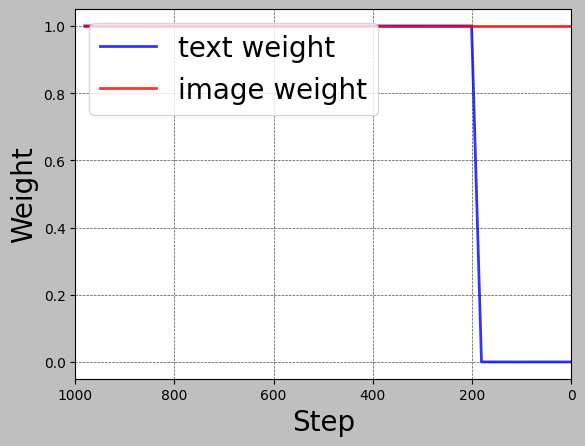

In [33]:
title = "Weights of Stepwise Model"
inference_steps, text_weights, ip_weights = ip_model_time.get_weights()
plot_weights(title, inference_steps, text_weights, ip_weights, f"./result/stepwise/weight/step{step}_ratio{ratio_idx}.png")